## By Jacob Turner

##### Import FEniCS module

In [64]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 
import numpy as np 
import sympy as sym 

##### Create the mesh on the domain that describes the battery cell. 

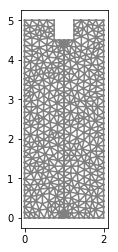

In [65]:
# enter battery domain dimensions
battery_height = 4.5
battery_width = 2.0
tab_height = 0.5
tab_width = 0.75

# cathode dimensions
cwidth = 0.00010 # cathode width
cdist = 0.10 # cathode distance from top and bottom of battery cell

# Main Cell Body
originx = originy = 0.0
cornerx = battery_width
cornery = battery_height

# Positive tab domain
pox = 0.0
poy = battery_height
pcx = tab_width
pcy = battery_height + tab_height

# Negative tab domain
nox = battery_width - tab_width
noy = battery_height
ncx = battery_width
ncy = pcy

# define cathode dimensions
cox = battery_width/2 - cwidth/2
coy = cdist
ccx = battery_width/2 + cwidth/2
ccy = battery_height - cdist

# Elements in mesh:
meshsize = 20

cell = Rectangle( dolfin.Point(originx,originy), dolfin.Point(cornerx,cornery))
ptab = Rectangle( dolfin.Point(pox, poy), dolfin.Point(pcx, pcy))
ntab = Rectangle( dolfin.Point(nox, noy), dolfin.Point(ncx, ncy))
cathode = Rectangle( dolfin.Point(cox, coy), dolfin.Point(ccx, ccy))

domain = cell + ptab + ntab - cathode

mesh = generate_mesh(domain, meshsize)
V = FunctionSpace(mesh, 'CG', 1)

plot(mesh)
plt.show()

##### Defining the heat source generation function.

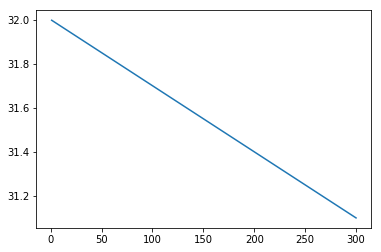

In [66]:
u = Function(V)
# define function that describes the heat generation in the battery 
def q(u) : 
    I = 2.0 # current of the battery (Amps)
    Vol = 10 # volume of the battery (mm^2)
    R = 80 # Internal Resistance of the battery (Ohms) [Increases y-intercept]
    V = - .015 # coefficient voltage variation with temperature in battery cell [Increases Slope]
    return (I/Vol)*(I*R + V*u)
# plotting the function
x = np.linspace(1,300, 1000)
plt.plot(x, q(x))

rho = Constant(1) #2000
Cp = Constant(1) #900
k = Constant(1) #1.6

##### Define values for the dirichlet boundary conditions of the battery cell. 

In [67]:
gD_top = Constant(35.0) #Expression('x[1]*x[1]', degree = 1) # Constant(100.0) # Dirichlet Boundaeies :top and bottom of battery are exposed to ambient temperature
gD_bottom = Constant(20.0)
gD_left = Constant(30.0)
gD_right = Constant(30.0)
# initial condtions in the battery cell.
u_int = Constant(1.0) #Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',degree=2, a=1)
#u_int = Expression('exp(-10*(x[0]*x[0] + x[1]*x[1]))', degree = 1) # Constant(1.0) #Expression('sin(x[0] + x[1])', degree = 1)#Constant(1.0) # Initial condition :begin at same temp as outside
u0 = interpolate(u_int, V)

##### Define boundaries of the battery cell. 

In [68]:
# defining parts of the boundaries by creating classes
class tab_top (SubDomain): 
    def inside (self , x , on_boundary): 
        return near( x[1], pcy)
# battery cell main core
class Left (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], originx)
class Right (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], cornerx)
class Bottom (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], originy)
class Top (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], cornery)
# create classes for cathode boundaries
class cathode_left (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[0], cox)
class cathode_right (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[0], ccx)
class cathode_top (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[1], coy)
class cathode_bottom (SubDomain):
    def inside (self, x, on_boundary):
        return near(x[1], ccy)

tab = tab_top()
    
# create each instance of the classess created above
left = Left()
right = Right()
top = Top()
bottom = Bottom()

# instantiate classes for the cathode boundaries
cleft = cathode_left()
cright = cathode_right()
ctop = cathode_top()
cbottom = cathode_bottom()

# Initialize mesh function for boundary domains and mark
boundaries = MeshFunction("size_t", mesh , 1) #
boundaries.set_all(0) #

left.mark(boundaries , 1)
top.mark(boundaries , 2)
right.mark(boundaries , 3)
bottom.mark(boundaries , 4)

cleft.mark(boundaries , 5)
ctop.mark(boundaries , 6)
cright.mark(boundaries , 7)
cbottom.mark(boundaries , 8)

tab.mark(boundaries , 9)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries) #

# dont apply these in simulation to use all neumann boundaries [Dirichlet BC Conds.]
bc_bottom = DirichletBC(V, gD_bottom, boundaries, 4)# bottom of the battery cell 
bc_top = DirichletBC(V, gD_top, boundaries, 9) # top of the tab bc
bc_right = DirichletBC(V, gD_right, boundaries, 3)# bottom of the battery cell 
bc_left = DirichletBC(V, gD_left, boundaries, 1) # top of the tab bc
bct = [bc_bottom, bc_top] # store dirichlet in array 

##### Declare values for nuemann boundaries of the battery cell.

In [69]:
# Heat flux from batteries on boundaries
# Neumann for left and right boundary
gN_left = Constant(10.0) 
gN_right = Constant(10.0)
# declare neumann for top and bottom boundaries if necessary.
gN_top = Constant(5.0)
gN_bottom = Constant(5.0)
# cathode boundary values
gN_cleft = q(u) #Constant(10.0) 
gN_cright = q(u) #Constant(10.0)
gN_ctop = q(u) #Constant(10.0)
gN_cbottom = q(u) #Constant(1.0)
# Tab neumann boundaries values
gN_tab = Constant(5.0)

##### Initiate time interval and step to run simulation over. 

In [70]:
#define time interval and step size
num_steps = 1000
T = 10.0
dt = T/num_steps
t = 0

##### Create variational problem

In [71]:
# variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = q(u) 

up = u0 # store u(t=0) in new var

F =  k*u*v*dx + rho*Cp*dt*inner(grad(u), grad(v))*dx \
- (u0 + dt*f)*v*dx - dt*gN_left*v*ds(1) - dt*gN_right*v*ds(3) \
- dt*gN_top*v*ds(2) - dt*gN_bottom*v*ds(4) - dt*gN_cleft*v*ds(5) \
- dt*gN_cright*v*ds(7) - dt*gN_ctop*v*ds(6) - dt*gN_cbottom*v*ds(8) \
- dt*gN_tab*v*ds(9) 

# create time dependence here?

a = lhs(F) # left hand side
L = rhs(F) # right hand side
A = assemble(a)
u = Function(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/jacobturner/anaconda3/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


##### Run the simulation over the previously entered time interval. 

In [72]:
vtkfile = File('Battery_paraview/final_simulations/final.pvd') # Store results of simulation here
t = 0 #initialize time
# time travel
for n in range(num_steps) :
    t += dt
    print("t = ", t)
    
    b = assemble(L)
    bc_bottom.apply(A,b) # apply bottom dirchlet
    bc_top.apply(A,b) # apply top dirchlet
    bc_left.apply(A,b) # apply left dirchlet
    bc_right.apply(A,b) # apply right dirchlet
    solve(A, u.vector(), b)
    
    n = FacetNormal(mesh)
    
    # compute the power transfer through each boundary
    flux = inner(grad(u0), n)*ds(4) #flux through bottom 
    power_bottom = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(2) #flux through top boundary
    power_top = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(3) #flux through right boundary
    power_right = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(1) #flux through left boundary
    power_left = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(9) #flux through left boundary
    power_tabs = assemble(flux) #integrate flux to get power
    
    # update
    up.assign(u)
    vtkfile << (u,t) # save

t =  0.01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/jacobturner/anaconda3/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


t =  0.02
t =  0.03
t =  0.04
t =  0.05
t =  0.060000000000000005
t =  0.07
t =  0.08
t =  0.09
t =  0.09999999999999999
t =  0.10999999999999999
t =  0.11999999999999998
t =  0.12999999999999998
t =  0.13999999999999999
t =  0.15
t =  0.16
t =  0.17
t =  0.18000000000000002
t =  0.19000000000000003
t =  0.20000000000000004
t =  0.21000000000000005
t =  0.22000000000000006
t =  0.23000000000000007
t =  0.24000000000000007
t =  0.25000000000000006
t =  0.26000000000000006
t =  0.2700000000000001
t =  0.2800000000000001
t =  0.2900000000000001
t =  0.3000000000000001
t =  0.3100000000000001
t =  0.3200000000000001
t =  0.3300000000000001
t =  0.34000000000000014
t =  0.35000000000000014
t =  0.36000000000000015
t =  0.37000000000000016
t =  0.38000000000000017
t =  0.3900000000000002
t =  0.4000000000000002
t =  0.4100000000000002
t =  0.4200000000000002
t =  0.4300000000000002
t =  0.4400000000000002
t =  0.45000000000000023
t =  0.46000000000000024
t =  0.47000000000000025
t =  0.48000

t =  3.5799999999999677
t =  3.5899999999999674
t =  3.5999999999999672
t =  3.609999999999967
t =  3.619999999999967
t =  3.6299999999999666
t =  3.6399999999999664
t =  3.649999999999966
t =  3.659999999999966
t =  3.6699999999999657
t =  3.6799999999999655
t =  3.6899999999999653
t =  3.699999999999965
t =  3.709999999999965
t =  3.7199999999999647
t =  3.7299999999999645
t =  3.7399999999999642
t =  3.749999999999964
t =  3.759999999999964
t =  3.7699999999999636
t =  3.7799999999999634
t =  3.789999999999963
t =  3.799999999999963
t =  3.8099999999999627
t =  3.8199999999999625
t =  3.8299999999999623
t =  3.839999999999962
t =  3.849999999999962
t =  3.8599999999999617
t =  3.8699999999999615
t =  3.8799999999999613
t =  3.889999999999961
t =  3.899999999999961
t =  3.9099999999999606
t =  3.9199999999999604
t =  3.92999999999996
t =  3.93999999999996
t =  3.9499999999999598
t =  3.9599999999999596
t =  3.9699999999999593
t =  3.979999999999959
t =  3.989999999999959
t =  3.99999

t =  7.149999999999892
t =  7.159999999999892
t =  7.169999999999892
t =  7.179999999999891
t =  7.189999999999891
t =  7.199999999999891
t =  7.209999999999891
t =  7.2199999999998905
t =  7.22999999999989
t =  7.23999999999989
t =  7.24999999999989
t =  7.25999999999989
t =  7.269999999999889
t =  7.279999999999889
t =  7.289999999999889
t =  7.299999999999889
t =  7.309999999999889
t =  7.319999999999888
t =  7.329999999999888
t =  7.339999999999888
t =  7.349999999999888
t =  7.3599999999998875
t =  7.369999999999887
t =  7.379999999999887
t =  7.389999999999887
t =  7.399999999999887
t =  7.4099999999998865
t =  7.419999999999886
t =  7.429999999999886
t =  7.439999999999886
t =  7.449999999999886
t =  7.459999999999885
t =  7.469999999999885
t =  7.479999999999885
t =  7.489999999999885
t =  7.4999999999998845
t =  7.509999999999884
t =  7.519999999999884
t =  7.529999999999884
t =  7.539999999999884
t =  7.5499999999998835
t =  7.559999999999883
t =  7.569999999999883
t =  7.579

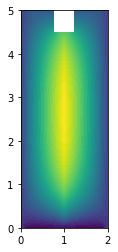

In [73]:
%matplotlib inline
plot(u)
plt.savefig(fname = "batt_temp_u.jpg", dpi = 500)
plt.show()

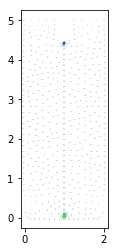

In [74]:
%matplotlib inline
#plot(mesh)
plot(-grad(u))
plt.savefig(fname = "gradient_u.jpg", dpi = 500)
plt.show()

##### Print heat transfer results through each of the relevent boundaries.

In [75]:
print("The energy transfer through the bottom boundary is {}".format(power_bottom), "Joules")
print("The energy transfer through the top boundary is {}".format(power_top), "Joules")
print("The energy transfer through he right boundary is {}".format(power_right), "Joules")
print("The energy transfer through the left boundary is {}".format(power_left), "Joules")
print("The energy transfer through the tabs is {}".format(power_tabs), "Joules")

The energy transfer through the bottom boundary is -98.05281505597266 Joules
The energy transfer through the top boundary is -1.8135158673939622 Joules
The energy transfer through the right boundary is -209.28846665890393 Joules
The energy transfer through the left boundary is -208.4925993436447 Joules
The energy transfer through the tabs is -22.94023161360867 Joules
